In [ ]:
import scipy.stats as sps
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from graphviz import Digraph

from statsmodels.stats.proportion import proportion_confint
from statsmodels.formula.api import ols

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', font_scale=1, palette='Set2')

In [ ]:
# Bot check

# HW_ID: ds_ab3
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

Со слов менеджера по развитию интернет-магазина:

> Коллеги, приветики! В прошлом месяце мы проводили эксперимент, в корзине покупателей поставили большую мигающую кнопку "Оплатить" ярко-зеленого цвета. Предполагаем, что покупатель будет быстрее переходить к оплате, не удаляя из корзины лишние товары. Ожидаем прирост выручки на 8-10%. Помогите, пожалуйста, по-скорее оценить эффект, очень горят сроки, скоро выплаты премий, надо успеть раскатить. В <a href="https://disk.yandex.ru/i/L64ohe5i6oz58A">файлике</a> инфа по клиентам, пилотные клиенты отмечены в столбце `b_group`. Спасибо огромное!

Поможем коллегам с их запросом.

___

Считаем данные.

In [ ]:
data = pd.read_excel('hw_ab3_task1.xlsx', index_col=0)
data.head()

,gender,OS,month1,month2,month3,month4,month5,month6,month7,month8,...,month10,month11,month12,month13,month14,month15,month16,month17,month18,b_group
0,woman,Android,0.000000,0.000000,1260.801227,1245.777408,0.000000,0.000000,1381.093860,1237.133907,...,1110.443064,0.000000,0.000000,0.000000,0.000000,1362.797130,1555.238727,0.000000,0.000000,no
1,man,Android,2142.521523,1821.295907,1832.895312,1646.448173,0.000000,2154.948644,1912.998501,1795.471291,...,0.000000,2253.871388,2526.126916,2861.138746,3068.924457,3384.232538,0.000000,0.000000,0.000000,yes
2,man,iOS,2064.105816,0.000000,0.000000,1454.148004,1821.118092,1917.801237,2188.827425,0.000000,...,1605.922754,0.000000,0.000000,1672.408077,1403.642040,1094.256738,962.442222,0.000000,1483.007220,no
3,woman,Android,1177.158341,1311.983158,0.000000,1302.464341,0.000000,0.000000,1479.573874,1356.655637,...,1713.852207,0.000000,0.000000,0.000000,1025.802676,1020.161834,949.921959,1029.725858,866.403692,yes
4,man,iOS,0.000000,2603.825002,2350.628045,2061.660828,1686.922097,0.000000,2720.638298,2541.299625,...,1920.793567,1879.833618,1991.184786,0.000000,2792.189328,2498.976500,2121.921368,2130.713432,2035.514926,no


Посмотрим на траты отдельных пользователей, видим периоды активности и неактивности, а также тренды в периоды активности

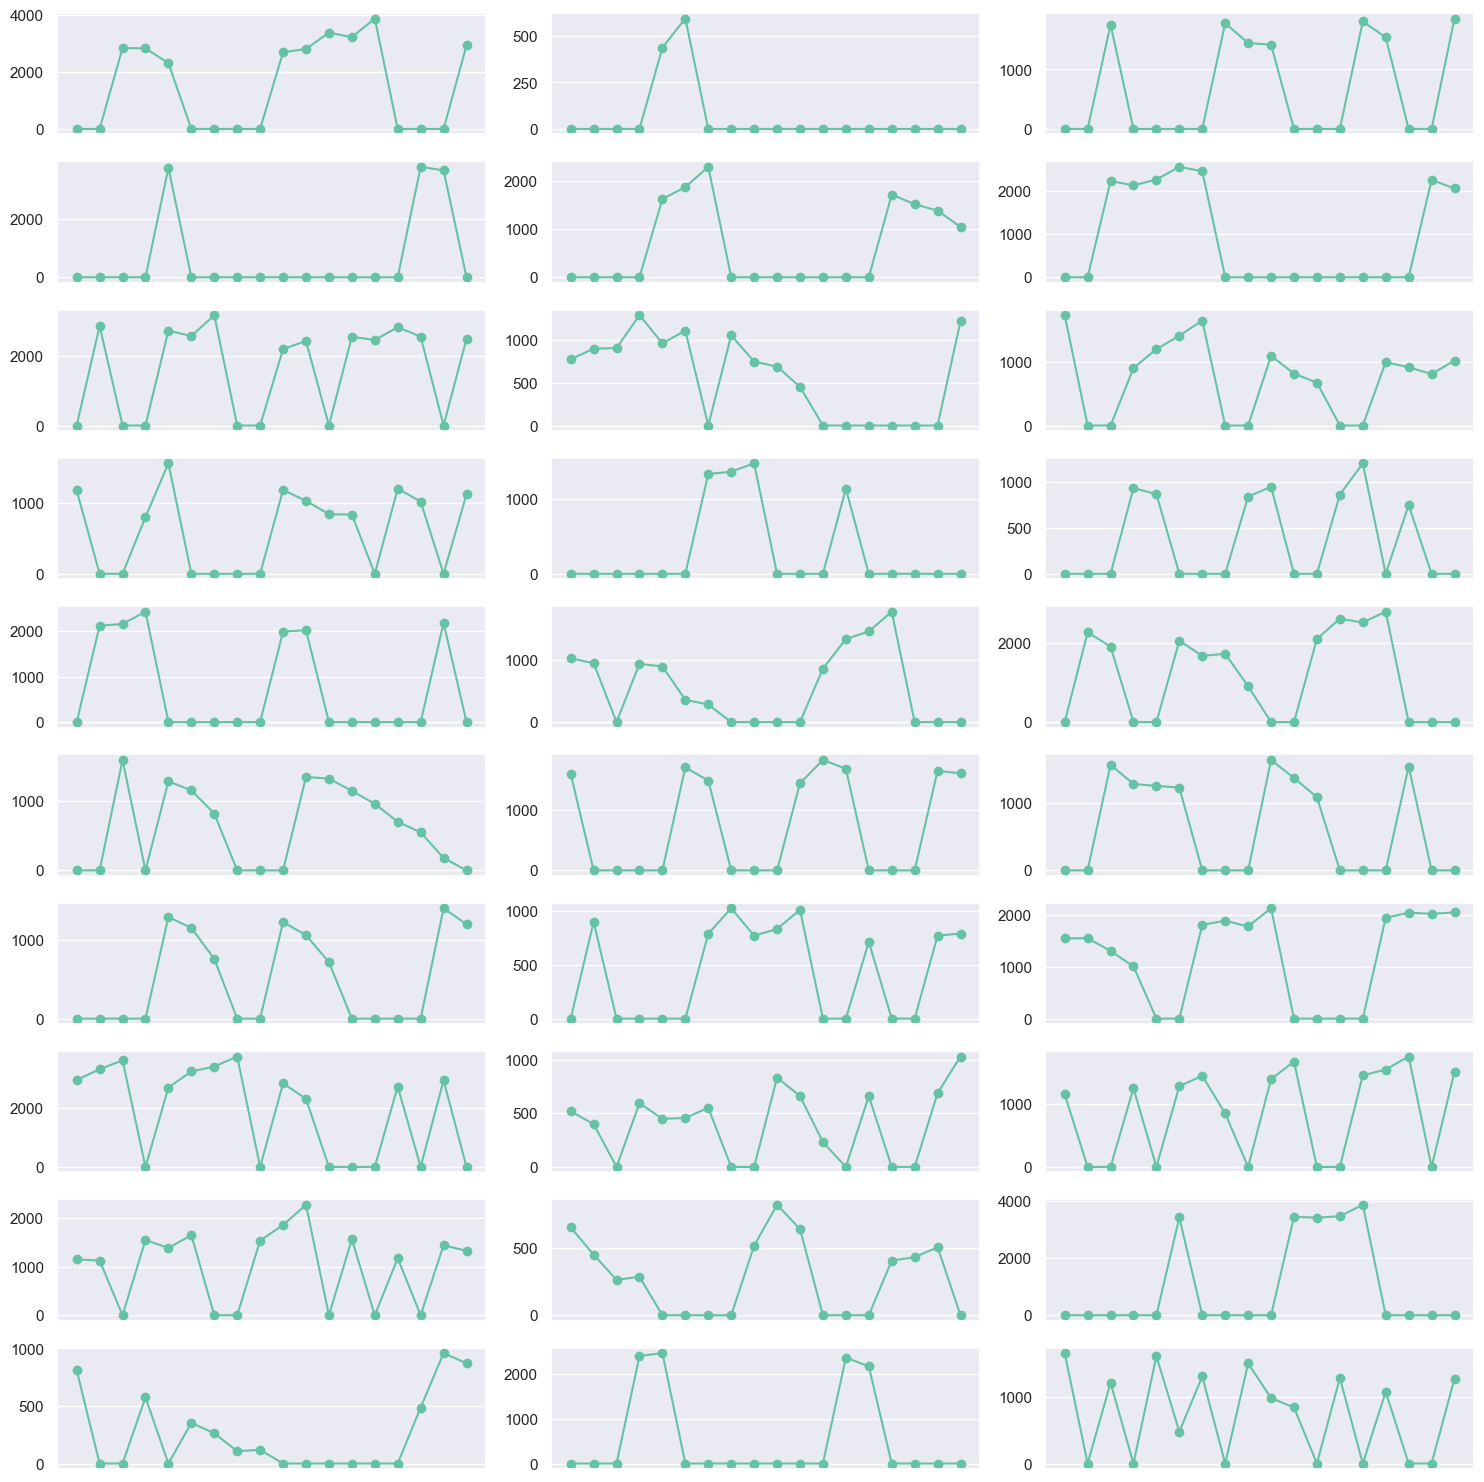

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(30):
    plt.subplot(10, 3, i+1)
    client_id = np.random.choice(range(len(data)), 1)
    plt.plot(data.iloc[client_id, 2:20].values.ravel(), '-o')
    plt.xticks([])
plt.tight_layout()

Посмотрим на распределение страт между группами.

**Пол**

In [ ]:
pd.set_option("display.precision", 3)
pd.crosstab(index=data['b_group'], columns=data['gender'], normalize='index')

gender,man,woman
b_group,,
no,0.532,0.468
yes,0.527,0.473


**Операционная система**

In [ ]:
pd.crosstab(index=data['b_group'], columns=data['OS'], normalize='index')

OS,Android,iOS
b_group,,
no,0.729,0.271
yes,0.732,0.268


Видим, что зависимостей в делении на группы от признаков *Пол* и *ОС* нет

Посмотрим на среднее значение трат по группам во времени до теста

In [ ]:
test_data = data[data['b_group'] == 'yes']
other_data = data[data['b_group'] == 'no']

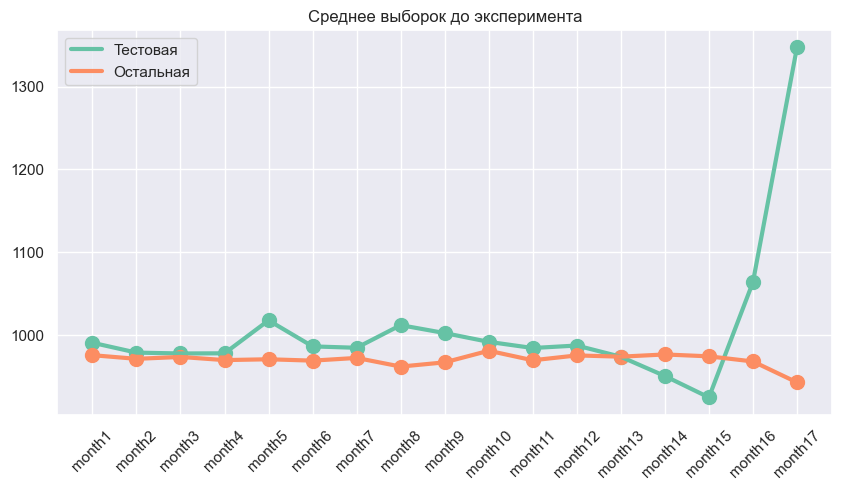

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Среднее выборок до эксперимента')

test_vals = test_data[[f'month{i}' for i in range(1, 18)]].mean()
plt.plot(test_vals, lw=3, label='Тестовая')
plt.scatter(np.arange(len(test_vals)), test_vals, s=100)

other_vals = other_data[[f'month{i}' for i in range(1, 18)]].mean()
plt.plot(other_vals, lw=3, label='Остальная')
plt.scatter(np.arange(len(test_vals)), other_vals, s=100)

plt.legend()
plt.xticks(rotation=45)
plt.show()

Тадам! Видим, что тестовой группе есть сильный всплеск до эксперимента. Значит, пользователи отбирались не случайно. Возможно, пользователей в тест брали с учетом их активности.

Посмотрим на распределение выручки в месяц до эксперимента.

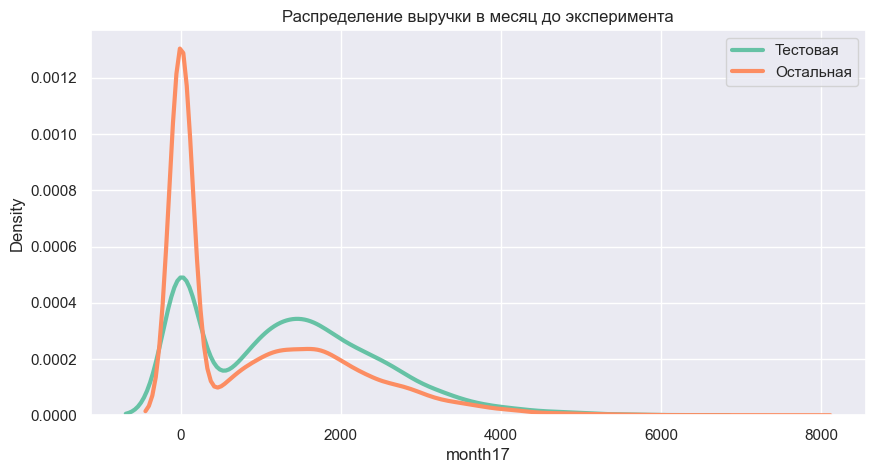

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Распределение выручки в месяц до эксперимента')

sns.kdeplot(test_data['month17'], lw=3, label='Тестовая')
sns.kdeplot(other_data['month17'], lw=3, label='Остальная')

plt.legend()
plt.show()

Видим, что покупатели, не попавшие в тест, чаще неактивные, чем покупатели, попавшие в тест. Добавим в наши данные признак, соответствующий активности пользователей в месяц до тестирования.

In [ ]:
data['month17_active'] = (data['month17'] > 0).astype(int)
pd.crosstab(index=data['b_group'], columns=data['month17_active'], normalize='index')

month17_active,0,1
b_group,,
no,0.481,0.519
yes,0.272,0.728


Видим, что действительно в тестовой группе больше активных в предтестовом месяце: почти 73% против почти 52%.

Для оценки результатов будем использовать бинарный признак активности в предтестовом месяце.

Возьмем функции для стратификации с семинара и напишем функцию для формирования датасета с нужными именами колонок таргет-метрики и стратификации.

In [ ]:
def create_AB_dataset(data, strata_name='strata', sample_name='sample', b_group_name='b_group'):
    dataAB = pd.DataFrame()
    dataAB['strata'] = data[strata_name]
    dataAB['sample'] = data[sample_name]
    dataAB['b_group'] = data[b_group_name]
    return dataAB

In [ ]:
def random_sampler(data, sample_size):
    '''
    Случайное семплирование двух групп одного размера из данных.

    :param data: исходные данные
    :param sample_size: размер группы
    :return: две группы данных
    '''

    choiced = data.sample(n=2 * sample_size)
    return choiced.iloc[:sample_size], choiced.iloc[sample_size:]


def sample_mean_diff(data, sample_size, n_iter):
    '''
    Реализация итераций семплирования двух случайных групп и вычисления разности средних.

    :param data: исходные данные
    :param sample_size: размер группы
    :param n_iter: количество итераций семплирования
    :return: выборка разности средних
    '''

    mean_sample = np.zeros(n_iter)

    for i in tqdm(range(n_iter)):
        groups = random_sampler(data, sample_size)
        mean_sample[i] = groups[0]['sample'].mean() - groups[1]['sample'].mean()

    return mean_sample

In [ ]:
def calculate_strata_weights(data):
    '''
    Вычисляет веса страт.

    :param data: исходные данные
    :return: веса страт
    '''

    strata_weights = data.groupby(by='strata')['sample'].count()
    strata_weights = strata_weights / strata_weights.sum()
    return strata_weights

In [ ]:
def weighted_mean(data, weights):
    '''
    Вычисляет взвешенное среднее.

    :param data: данные
    :param weights: веса страт
    :return: взвешенное среднее
    '''

    strata_means = data.groupby(by='strata')['sample'].mean()
    return (strata_means * weights).sum()


def simple_mean(data, weights):
    '''
    Вычисляет обычное выборочное среднее

    :param data: данные
    :param weights: не используется, нужен для совместимости
    :return: выборочное среднее
    '''

    return data['sample'].mean()


def sample_mean_diff(sampler, mean_function, data, sample_size, n_iter):
    '''
    Реализация итераций семплирования двух групп и вычисления разности средних.

    :param sampler: функция семплирования двух групп
    :param mean_function: функция вычисления среднего
    :param data: исходные данные
    :param sample_size: размер группы
    :param n_iter: количество итераций семплирования
    :return: выборка разности средних
    '''

    # Веса страт
    strata_weights = calculate_strata_weights(data)

    mean_sample = np.zeros(n_iter)

    for i in tqdm(range(n_iter)):
        # Семплирование
        groups = sampler(data, sample_size)
        # Вычисление разности средних
        mean_sample[i] = mean_function(groups[0], strata_weights) - \
                        mean_function(groups[1], strata_weights)

    return mean_sample

In [ ]:
def weighted_var(data, strata_weights):
    '''
    Вычисляет взвешенную дисперсию при стратификации.

    :param data: данные
    :param strata_weights: веса страт
    :return: дисперсия
    '''

    strata_vars = data.groupby(by='strata')['sample'].var()
    return (strata_vars * strata_weights).sum() / len(data)


def weighted_post_var(data, strata_weights):
    '''
    Вычисляет взвешенную дисперсию при постстратификации.

    :param data: данные
    :param strata_weights: веса страт
    :return: дисперсия
    '''

    strata_vars = data.groupby(by='strata')['sample'].var()
    weighted_var = (strata_vars * strata_weights).sum() / len(data)
    post_addition = (strata_vars * (1-strata_weights)).sum() / (len(data)**2)
    return weighted_var + post_addition


def simple_var(data, strata_weights):
    '''
    Вычисляет обычную дисперсию при случайном семплировании.

    :param data: данные
    :param strata_weights: веса страт, не используется, нужен для совместимости
    :return: дисперсия
    '''

    return data['sample'].var() / len(data)

In [ ]:
def stratified_ttest(x_data, y_data, strata_weights, method='random', alpha=0.05):
    '''
    Универсальный стратифицированный абсолютный t-test.

    :param x_data: выборка вместе с информацией о стратах
    :param y_data: выборка вместе с информацией о стратах
    :param strata_weights: веса страт
    :param method: метод 'random', 'stratified', 'post_stratified'
    :param alpha: уровень значимости
    :return: статистика критерия, границы доверительного интервала, p-value
    '''

    if method == 'random':
        mean_function = simple_mean
        var_function = simple_var
    elif method == 'stratified':
        mean_function = weighted_mean
        var_function = weighted_var
    elif method == 'post_stratified':
        mean_function = weighted_mean
        var_function = weighted_post_var

    x_mean = mean_function(x_data, strata_weights)
    y_mean = mean_function(y_data, strata_weights)
    x_var  =  var_function(x_data, strata_weights)
    y_var  =  var_function(y_data, strata_weights)

    stat = x_mean - y_mean
    std = np.sqrt(x_var + y_var)

    t_stat = stat / std
    pvalue = 2*sps.norm.sf(np.abs(t_stat))

    q = sps.norm.ppf(1 - alpha/2)
    left_bound = stat - q*std
    right_bound = stat + q*std

    return stat, pvalue, left_bound, right_bound

### CUPED через линейную регрессию по предыдущим 2 месяцам

In [ ]:
def regression_ttest(x_data, y_data, cuped=False, sample_name='pilot',
                     treatment_name='treatment', covariate_names=[]):
    '''
    T-test с CUPED/без CUPED, реализованный через линейную регрессию

    Аргументы:
    x, y -- выборки одинакового размера
    :param cuped: применять ли cuped
    :param sample_name: имя столбца с целевым признаком
    :param covariate_names: массив имен столбцов-ковариат

    Возвращает:
    stat -- статистика критерия
    pvalue
    left_bound, right_bound -- границы дов. интервала
    '''

    # добавляем столбец с индикатором тестовой группы
    x_data[treatment_name] = 1
    y_data[treatment_name] = 0
    # объединяем тест и контроль в один датасет
    data = pd.concat([x_data, y_data])

    # определяем имена фичей, на которых будем обучать модель
    if cuped:
        feature_names = [treatment_name] + list(covariate_names)
    else:
        feature_names = [treatment_name]

    # обучаем модель
    model = ols(f'{sample_name} ~ '+ '+'.join(feature_names), data=data).fit()
    # забираем таблицу с результатами
    summary = model.summary2().tables[1]
    # берем из таблицы нужные поля
    stat = summary.loc[treatment_name, 't']
    pvalue = summary.loc[treatment_name, 'P>|t|']
    left_bound = summary.loc[treatment_name, '[0.025']
    right_bound = summary.loc[treatment_name, '0.975]']
    return stat, pvalue, left_bound, right_bound

In [ ]:
test_data = data[data['b_group'] == 'yes']
control_data, _ = random_sampler(
    data[data['b_group'] == 'no'],
    sample_size=len(test_data),
)

In [ ]:
stat, pvalue, left_bound, right_bound = regression_ttest(control_data, test_data,
                                        cuped=True, sample_name='month18',
                                        covariate_names=['month16', 'month17'])
print(f'p-value: {np.round(pvalue, 4)}')
print(f'эффект: {np.round((left_bound + right_bound) / 2, 1)}')
print(f'дов. интервал для эффекта: {np.round(left_bound, 1), np.round(right_bound, 1)}')
print(f'значимость эффекта: {pvalue < 0.05}')

p-value: 0.0016
эффект: 86.1
дов. интервал для эффекта: (32.7, 139.5)
значимость эффекта: True


**Вывод:** в этой задаче мы имели дело с несопоставимыми выборками: тестовая группа имела явный перекос в таргет-метрике на предпериоде. Это было вызвано тем, что в тестовой группе оказалось больше активных пользователей. Из-за этого нельзя говорить о корректно проведенном АБ-тесте.

Однако, оценить эффект в данном случае все равно можно.